In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [264]:
class LinearLayer:
    # A linear layer of shape (d_in × d_out) with (tp_in × tp_out)-degree tensor
    # parallelism, dp-degree data parallelism, and bytewidth precision.
    def __init__(self, d_in, d_out, tp_in, tp_out, dp, bytewidth):
        self.d_in = d_in
        self.d_out = d_out
        self.tp_in = tp_in
        self.tp_out = tp_out
        self.dp = dp
        self.bytewidth = bytewidth

        # Derived dimensions.
        self.N = d_in*d_out                             # number of parameters
        self.d_in_local = d_in/tp_in                    # local input dimension
        self.d_out_local = d_out/tp_out                 # local output dimension
        self.N_local = self.d_in_local*self.d_out_local # local number of parameters

class ChinchillaOptimalModel:
    def __init__(self, training_flop, hidden_factor=5, bytewidth=2):
        self.training_flop = training_flop
        self.bytewidth = bytewidth
        self.hidden_factor = hidden_factor
        self.N = np.sqrt(training_flop/120)               # number of parameters
        self.D = 20*self.N                                # number of training tokens
        self.B = 4e6 * (training_flop/1e25)**(1/6)        # batch size
        self.L = 120 * (training_flop/1e25)**(1/6)        # number of layers
        self.d = np.sqrt(self.N/(2*hidden_factor*self.L)) # residual dimension

class Device:
    def __init__(self, name, flop_per_sec_8bit, global_Bps, net_Bps,
                 base_util=0.8):
        self.name = name
        self.flop_per_sec_8bit = flop_per_sec_8bit
        self.global_Bps = global_Bps
        self.net_Bps = net_Bps
        self.base_util = base_util

    def __repr__(self):
        return self.name
    
    def all_reduce_communication(self, n, p):
        # The number of words this device has to send or receive to participate
        # in an all-reduce of a vector of local size n, with p - 1 other
        # devices.
        #
        # We assume a bandwidth-optimal reduce-scatter + multicast communication
        # pattern, where each device is responsible for reducing n/p words:
        #
        #  Step 1. Transmit p - 1 parts of size n/p to the devices responsible
        #          for reducing those parts.
        #
        #  Step 2. Receive p - 1 copies of the part of size n/p that I'm
        #          responsible for reducing from my peers.
        #
        #  Step 3. Reduce the p copies of my part and multicast the result to my
        #          peers (optimistically assumed to be free for simplicity).
        #
        #  Step 4. Receive p - 1 parts of size n/p that my peers were
        #          responsible for reducing.
        return 3*(p - 1)*n/p

    def linear_layer_fwd_bwd_secs(self, lin_layer, b):
        # Determine the time to compute a forward and backward pass through
        # lin_layer on a microbatch of b tokens. We take into account the time
        # of tensor FLOP, global memory IO, and tensor-parallel all-reduce
        # communication.
        #
        # Some assumptions (all "optimistic"):
        #  - Data movement and computation are fully overlappable, via the
        #    mechanism of multiple microbatches simultaneously in flight.
        #
        #  - Pipeline-parallel communication time is negligible (though deep
        #    pipelines may cause a bubble, which is modeled elsewhere).
        #
        #  - Pointwise operations such as activation functions and
        #    normalizations are negligible. So is attention and any
        #    communication it requires.
        #
        #  - b/dp is substantially smaller than d_in/tp_in and d_out/tp_out,
        #    where dp is the data parallel degree, tp_in is the input tensor
        #    parallel degree, and tp_out is the output tensor parallel degree.
        #    This is because this tends to be communication-optimal due to the
        #    significant communication costs of tensor parallelism compared to
        #    data parallelism. This in turn has a few implications:
        #
        #     1. The input and output matrix tends to be quite rectangular,
        #        which puts the on-chip data movement bottleneck at global
        #        memory rather than shared memory banks, L2 cache, or the
        #        SM-to-SM DSMEM network. This is because the SM- and warp-level
        #        tiles can still be large and approximately square-shaped, which
        #        removes these levels of the memory hierarchy as a bottleneck,
        #        however there isn't freedom to do this at the global level.
        #        Thus we do not model data movement on-chip except to/from
        #        global memory.
        #
        #     2. We assume activations and their gradients fit in L2 cache when
        #        they've recently been accessed (e.g. by a recent network
        #        receive, all-reduce, or the previous layer's matmul), but
        #        weights and their gradients cannot. Thus we only model global
        #        memory IO for weights and gradients, except on the backward
        #        pass where activations must be reloaded from global memory
        #        (where they are presumed to fit, avoiding the need for
        #        activation recomputation).
        #
        #  - The all-reduce communication pattern is a bandwidth-optimal
        #    reduce-scatter followed by a multicast, and we treat the multicast
        #    transmission as free for simplicity.
        #
        # We also don't worry about whether our parallelism degrees divide the
        # tensor dimensions.
        d_in_local, d_out_local = lin_layer.d_in_local, lin_layer.d_out_local
        N_local = lin_layer.N_local
        tp_in, tp_out, dp = lin_layer.tp_in, lin_layer.tp_out, lin_layer.dp
        bytewidth = lin_layer.bytewidth
        b_local = b/dp

        flop, global_io, net_io = 0, 0, 0

        # Forward pass.
        global_io += N_local                                                   # Load weights.
        flop      += 2*N_local*b_local                                         # Compute output activations: Y = WX.
        net_io    += self.all_reduce_communication(d_out_local*b_local, tp_in) # All-reduce activations (network IO).
        global_io += self.all_reduce_communication(d_out_local*b_local, tp_in) # All-reduce activations (global memory IO).

        # Backward pass (weight gradients).
        global_io += d_in_local*b_local                                        # Reload input activations from global memory.
        flop      += 2*N_local*b_local                                         # Compute weight gradients: dL/dW = (dL/dY)X^T.
        global_io += 2*N_local                                                 # Accumulate weight gradients (read + write).
    
        # Backward pass (activation gradients).
        global_io += N_local                                                   # Load weights.
        flop      += 2*N_local*b_local                                         # Compute input gradients: dL/dX = W^T(dL/dY).
        net_io    += self.all_reduce_communication(d_in_local*b_local, tp_out) # All-reduce input gradients (network IO).
        global_io += self.all_reduce_communication(d_in_local*b_local, tp_out) # All-reduce input gradients (global memory IO).

        # Total time. base_util due to thermal throttling is presumed to affect
        # FLOP/s and global memory B/s, but not net B/s.
        flop_secs = (flop*bytewidth)/(self.base_util*self.flop_per_sec_8bit)
        global_io_secs = (global_io*bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (net_io*bytewidth)/self.net_Bps
        return np.maximum(flop_secs, np.maximum(global_io_secs, net_io_secs))

    def linear_layer_end_of_batch_secs(self, lin_layer):
        # Determine the time for the end-of-batch gradient all-reduce (we assume
        # the optimizer step itself is negligible).
        io = self.all_reduce_communication(lin_layer.N_local, lin_layer.dp)
        global_io_secs = (io*lin_layer.bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (io*lin_layer.bytewidth)/self.net_Bps
        return np.maximum(global_io_secs, net_io_secs)

    def model_batch_secs(self, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch):
        # Determine the time to train on a single batch of the given model,
        # given the provided parallelism degrees.

        # Construct the two linear layers for each residual block.
        lin1 = LinearLayer(model.d, model.hidden_factor*model.d, tp_residual, tp_hidden, dp, model.bytewidth)
        lin2 = LinearLayer(model.hidden_factor*model.d, model.d, tp_hidden, tp_residual, dp, model.bytewidth)

        # Determine the number of pipeline steps, in the bubble and at steady
        # state. Since we optimistically treat pipeline-parallel communication
        # as free, we assume maximal interleaving to minimize bubble fraction.
        assert np.all(pp <= model.L), f"pp={pp}, L={model.L}"
        assert np.all(pp <= n_microbatches_per_batch), f"pp={pp}, n_microbatches_per_batch={n_microbatches_per_batch}"
        layers_per_stage = model.L/pp
        pipeline_bubble_steps = pp - 1
        pipeline_full_steps = layers_per_stage*n_microbatches_per_batch
        total_steps = pipeline_bubble_steps + pipeline_full_steps

        # Determine the microbatch size.
        b = model.B / n_microbatches_per_batch
        step_secs = self.linear_layer_fwd_bwd_secs(lin1, b) + self.linear_layer_fwd_bwd_secs(lin2, b)
        block_end_of_batch_secs = self.linear_layer_end_of_batch_secs(lin1) + self.linear_layer_end_of_batch_secs(lin2)

        pipeline_bubble_secs = pipeline_bubble_steps*step_secs
        pipeline_full_secs = pipeline_full_steps*step_secs
        gradient_secs = layers_per_stage*block_end_of_batch_secs
        return total_steps*step_secs + pipeline_bubble_secs + gradient_secs,\
            (pipeline_bubble_secs, pipeline_full_secs, gradient_secs)

    def model_train_secs(self, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch):
        num_batches = model.D/model.B
        batch_secs, _ = self.model_batch_secs(model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch)
        return num_batches*batch_secs

In [324]:
def expand_pareto_frontier(device, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch,
                           pp2=None, dp2=None, tp_residual2=None, tp_hidden2=None, n_microbatches_per_batch2=None):
    pp2 = pp2 if pp2 is not None else pp
    dp2 = dp2 if dp2 is not None else dp
    tp_residual2 = tp_residual2 if tp_residual2 is not None else tp_residual
    tp_hidden2 = tp_hidden2 if tp_hidden2 is not None else tp_hidden
    n_microbatches_per_batch2 = n_microbatches_per_batch2 if n_microbatches_per_batch2 is not None else n_microbatches_per_batch

    pp = np.minimum(np.concatenate((pp, pp2)), model.L)
    dp = np.concatenate((dp, dp2))
    tp_residual = np.concatenate((tp_residual, tp_residual2))
    tp_hidden = np.concatenate((tp_hidden, tp_hidden2))
    n_microbatches_per_batch = np.maximum(np.concatenate((n_microbatches_per_batch, n_microbatches_per_batch2)),
                                          pp)

    n_devices = pp*dp*tp_residual*tp_hidden
    training_secs = device.model_train_secs(model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch)

    # Sort by number of devices.
    sort_indices = np.argsort(n_devices)
    pp = pp[sort_indices]
    dp = dp[sort_indices]
    tp_residual = tp_residual[sort_indices]
    tp_hidden = tp_hidden[sort_indices]
    n_microbatches_per_batch = n_microbatches_per_batch[sort_indices]
    n_devices = n_devices[sort_indices]
    training_secs = training_secs[sort_indices]

    # Remove dominated points.
    dominated = training_secs > np.minimum.accumulate(training_secs)
    pp = pp[~dominated]
    dp = dp[~dominated]
    tp_residual = tp_residual[~dominated]
    tp_hidden = tp_hidden[~dominated]
    n_microbatches_per_batch = n_microbatches_per_batch[~dominated]
    return pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch

In [325]:
device = Device('H100 SXM5', 1979e12, 3352e9, 900e9)
model = ChinchillaOptimalModel(1e27)

# pp = np.array([1])
# dp = np.array([1])
# tp_residual = np.array([1])
# tp_hidden = np.array([1])
# n_microbatches_per_batch = np.array([1])

# for i in range(7):
#     pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch = expand_pareto_frontier(device, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch,
#                                                                                     pp2=pp*2)
#     pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch = expand_pareto_frontier(device, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch,
#                                                                                     dp2=dp*2)
#     pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch = expand_pareto_frontier(device, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch,
#                                                                                     tp_residual2=tp_residual*2)
#     pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch = expand_pareto_frontier(device, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch,
#                                                                                     tp_hidden2=tp_hidden*2)
#     pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch = expand_pareto_frontier(device, model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch,
#                                                                                     n_microbatches_per_batch2=n_microbatches_per_batch*2)


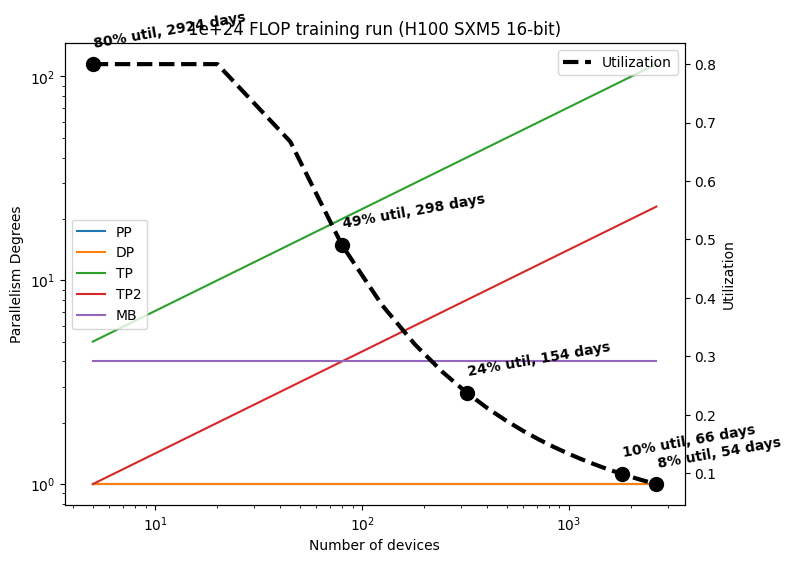

In [343]:
device = Device('H100 SXM5', 1979e12, 3352e9, 900e9)
model = ChinchillaOptimalModel(1e24)

tp_hidden = np.arange(1, 24)
tp_residual = tp_hidden*model.hidden_factor
pp = np.ones_like(tp_hidden)
dp = np.ones_like(tp_hidden)
n_microbatches_per_batch = 4*pp

n_devices = pp*dp*tp_residual*tp_hidden
training_secs = device.model_train_secs(model, pp, dp, tp_residual, tp_hidden, n_microbatches_per_batch)
training_days = training_secs/86400
theoretical_flop_per_sec = n_devices*device.flop_per_sec_8bit/model.bytewidth
actual_flop_per_sec = model.training_flop/training_secs
util = actual_flop_per_sec/theoretical_flop_per_sec

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{model.training_flop} FLOP training run ({device.name} {model.bytewidth*8}-bit)')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(n_devices, pp, label='PP')
ax.plot(n_devices, dp, label='DP')
ax.plot(n_devices, tp_residual, label='TP')
ax.plot(n_devices, tp_hidden, label='TP2')
ax.plot(n_devices, n_microbatches_per_batch, label='MB')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    # i = np.argmin(np.abs(n_devices - n))
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(100*util[i]))}% util, {int(np.round(training_days[i]))} days', (n_devices[i], util[i]), xytext=(0, 10),
                 textcoords='offset points', ha='left', va='bottom', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
ax.legend(loc='center left')
ax2.legend()

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{model.training_flop} FLOP training run ({device.name} {model.bytewidth*8}-bit)')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(n_devices, pp, label='PP')
ax.plot(n_devices, dp, label='DP')
ax.plot(n_devices, tp_residual, label='TP')
ax.plot(n_devices, tp_hidden, label='TP2')
ax.plot(n_devices, n_microbatches_per_batch, label='MB')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    # i = np.argmin(np.abs(n_devices - n))
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(100*util[i]))}% util, {int(np.round(duration_days[i]))} days', (n_devices[i], util[i]), xytext=(0, 10),
                 textcoords='offset points', ha='left', va='bottom', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
ax.legend(loc='center left')
ax2.legend()